## Création de l'environnement

In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
import numpy as np
from grid2op.Parameters import Parameters
import shutil
import os
from lightsim2grid import LightSimBackend

In [2]:
p = Parameters()
p.NO_OVERFLOW_DISCONNECTION = True
env = grid2op.make("l2rpn_wcci_2022", param=p, backend=LightSimBackend())
# env = grid2op.make("educ_case14_storage", test=True, param=p)
plot_helper = PlotMatplot(env.observation_space)

In [3]:
action = env.action_space()

In [4]:
print(action)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


## Affichage de l'environnement

/home/gaetan/miniconda3/envs/L2RPN/lib/python3.9/site-packages/grid2op/PlotGrid/PlotMatplot.py:1064: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  figure.tight_layout()


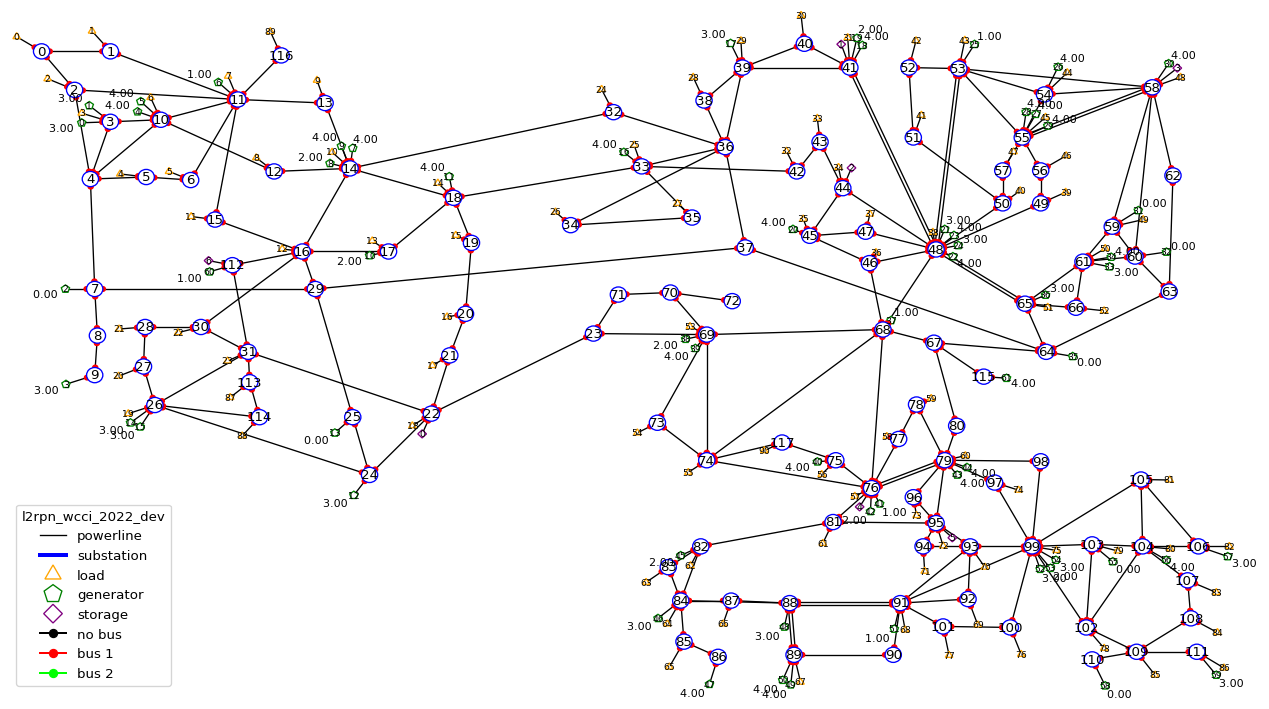

In [5]:
# _ = plot_helper.plot_info(line_values=env._thermal_limit_a, coloring="line", gen_values=env.gen_pmax, storage_values=env.storage_max_p_prod)
dict = {'nuclear':0, 'thermal':1, 'hydro':2, 'wind':3, 'solar':4}
_ = plot_helper.plot_info(gen_values=[dict[el] for el in env.gen_type])

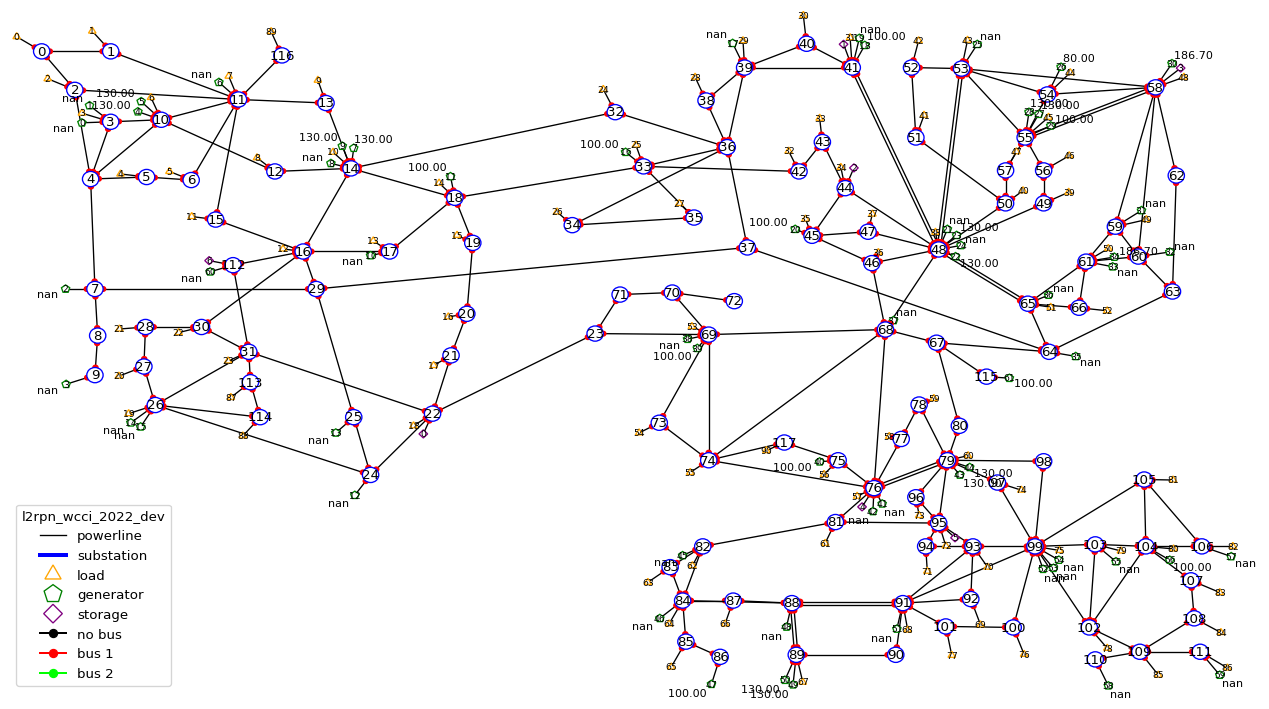

In [6]:
_ = plot_helper.plot_info(gen_values=np.array([env.gen_pmax[i] if env.gen_type[i]=="solar" else None for i in range(env.n_gen)], dtype=np.float64))

In [9]:
env.gen_type.shape

(62,)

In [10]:
env.chronics_handler.real_data.available_chronics()

array(['/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_0',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_1',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_2',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_3',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_4',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_5',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_6',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_7',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_8',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_9',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-10_0',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-10_1',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-10_2',
       '/home/gaetan/data_grid2op/l2rp

In [11]:
env.max_episode_duration()

2017

## Runner

In [12]:
np.random.seed(42)
chronics_to_use = np.random.choice(env.chronics_handler.real_data.available_chronics(), 20, replace=False)

In [13]:
chronics_to_use

array(['/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-07-11_5',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-03-07_3',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-01-03_6',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-04-25_7',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-03-07_0',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-12-26_3',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-09-12_2',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-06-06_8',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-05-16_2',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-12-05_2',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-05-30_8',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-05-09_0',
       '/home/gaetan/data_grid2op/l2rpn_wcci_2022/chronics/2050-08-01_7',
       '/home/gaetan/data_grid2op/l2rp

In [15]:
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent, RecoPowerlineAgent

env.chronics_handler.real_data.set_filter(lambda x: x in chronics_to_use)
env.chronics_handler.real_data.reset()

path_agents = "output_agents_no_overflow"

os.makedirs(path_agents, exist_ok=True)

for agentClass, agentName in zip([DoNothingAgent], #, RecoPowerlineAgent],
                                 ["DoNothingAgent"]):#, "RecoPowerlineAgent"]):
    env.seed(0)
    path_this_agent = os.path.join(path_agents, agentName)
    shutil.rmtree(os.path.abspath(path_this_agent), ignore_errors=True)
    runner = Runner(**env.get_params_for_runner(),
                    agentClass=agentClass
                    )
    res = runner.run(path_save=path_this_agent, nb_episode=20) #, max_iter=max_iter)
    print("The results for the {} agent are:".format(agentName))
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

The results for the DoNothingAgent agent are:
	For chronics with id 2050-01-03_6
		 - cumulative reward: 434798.187500
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-01-10_0
		 - cumulative reward: 428698.031250
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-01-24_0
		 - cumulative reward: 419457.562500
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-03-07_0
		 - cumulative reward: 423518.687500
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-03-07_3
		 - cumulative reward: 419777.406250
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-04-04_7
		 - cumulative reward: 451082.968750
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-04-25_7
		 - cumulative reward: 482184.687500
		 - number of time steps completed: 2017 / 2017
	For chronics with id 2050-05-09_0
		 - cumulative reward: 519384.312500
		 - number of time steps c

In [16]:
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
   msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
   msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}\n".format(nb_time_step, max_ts)
   days_survived = (nb_time_step - 1) / (max_ts - 1) * 7
   msg_tmp += "\t\t - Moment of game over : day {} at {}h{}".format(int(days_survived), int(days_survived % 1 * 24), 
                                                                     int(days_survived % 1 * 24 % 1 * 60))
   print(msg_tmp)

	For chronics with id 2050-01-03_6
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-01-10_0
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-01-24_0
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-03-07_0
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-03-07_3
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-04-04_7
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-04-25_7
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chronics with id 2050-05-09_0
		 - number of time steps completed: 2017 / 2017
		 - Moment of game over : day 7 at 0h0
	For chr

## Study your episode

In [17]:
from grid2op.Episode import EpisodeData

In [18]:
EpisodeData.list_episode(os.path.join(path_agents, "DoNothingAgent"))[0]

('/home/gaetan/Documents/Projects/L2RPN-WCCI-Baselines/RL/output_agents_no_overflow/DoNothingAgent',
 '2050-01-03_6')

In [19]:
this_episode = EpisodeData.from_disk(os.path.join(path_agents, "DoNothingAgent"), "2050-01-10_0")

In [20]:
import datetime
for obs in this_episode.observations:
    print(datetime.datetime(year=obs.year,
         month=obs.month,
         day=obs.day,
         hour=obs.hour_of_day,
         minute=obs.minute_of_hour))

2050-01-10 00:00:00
2050-01-10 00:05:00
2050-01-10 00:10:00
2050-01-10 00:15:00
2050-01-10 00:20:00
2050-01-10 00:25:00
2050-01-10 00:30:00
2050-01-10 00:35:00
2050-01-10 00:40:00
2050-01-10 00:45:00
2050-01-10 00:50:00
2050-01-10 00:55:00
2050-01-10 01:00:00
2050-01-10 01:05:00
2050-01-10 01:10:00
2050-01-10 01:15:00
2050-01-10 01:20:00
2050-01-10 01:25:00
2050-01-10 01:30:00
2050-01-10 01:35:00
2050-01-10 01:40:00
2050-01-10 01:45:00
2050-01-10 01:50:00
2050-01-10 01:55:00
2050-01-10 02:00:00
2050-01-10 02:05:00
2050-01-10 02:10:00
2050-01-10 02:15:00
2050-01-10 02:20:00
2050-01-10 02:25:00
2050-01-10 02:30:00
2050-01-10 02:35:00
2050-01-10 02:40:00
2050-01-10 02:45:00
2050-01-10 02:50:00
2050-01-10 02:55:00
2050-01-10 03:00:00
2050-01-10 03:05:00
2050-01-10 03:10:00
2050-01-10 03:15:00
2050-01-10 03:20:00
2050-01-10 03:25:00
2050-01-10 03:30:00
2050-01-10 03:35:00
2050-01-10 03:40:00
2050-01-10 03:45:00
2050-01-10 03:50:00
2050-01-10 03:55:00
2050-01-10 04:00:00
2050-01-10 04:05:00


/home/gaetan/miniconda3/envs/L2RPN/lib/python3.9/site-packages/grid2op/PlotGrid/PlotMatplot.py:1064: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  figure.tight_layout()


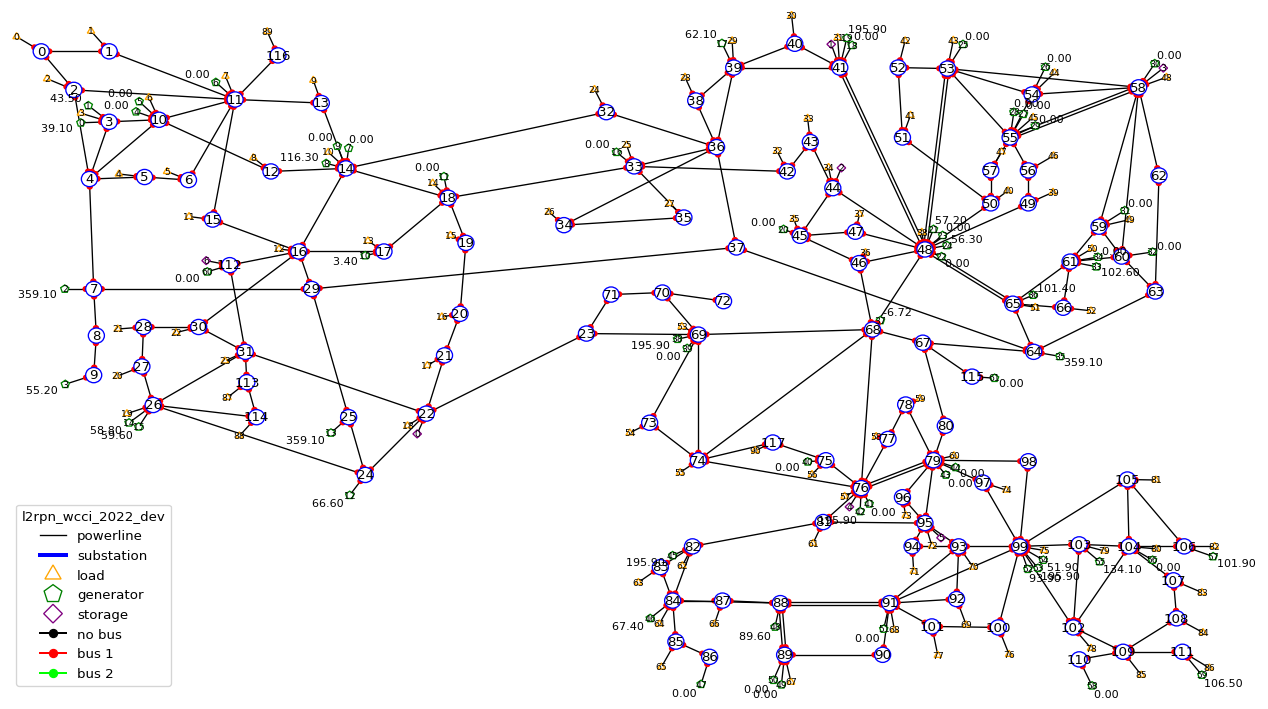

In [21]:
_ = plot_helper.plot_info(gen_values=this_episode.observations[-2].gen_p)

## Check normalization

In [22]:
from grid2op.gym_compat import BoxGymObsSpace, GymEnv

In [66]:
env_gym = GymEnv(env)
obs_attr_to_keep = ["load_p", "p_or"]
obs_attr_to_keep = ["load_p"]
env_gym.observation_space = BoxGymObsSpace(env.observation_space, attr_to_keep=obs_attr_to_keep)

In [67]:
# Normalize the keeped observation attributes
for attr_nm in obs_attr_to_keep:
    env_gym.observation_space.normalize_attr(attr_nm)

print(env_gym.observation_space)

obs = env_gym.reset()
print(obs.min(), obs.max())

Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf], (91,), float32)
2.4 117.6


In [68]:
obs = env.reset()
env_gym.observation_space.to_gym(obs).shape, env_gym.observation_space.to_gym(obs)

((91,),
 array([ 47.1,  19.7,  38.7,  29.8,  53.9,  19.7,  68.5,  50.7,  35. ,
         14.6, 100.9,  26.2,  10.6,  65.4,  48.6,  19.7,  15.5,  11. ,
          7.8,  64.2,  17.2,  24.6,  43.9,  60.2,  15.7,  41.5,  23.7,
         21.6,  17.5,  12.7,  23.5,  23.7,  11.6,   9.9,  33.9,  18.3,
         21.4,  12.7,  56.8,  10.2,  10.8,  11.2,  13.8,  66.3,  39.6,
         52.3,   7.6,   7.1, 178.6,  46.7,  50. ,  26.1,  18. ,  66.7,
         66.4,  48.6,  42.7,  37.7,  47.3,  24.4,  80.9,  89.5,  29.7,
         17.9,  37.8,  35.5,  74.5, 128.7, 102. ,  20.6,  48.5,  68.7,
         62.1,   9.9,  22.3,  59.1,  34.8,   7.6,  37.3,  60.9,  49.7,
         71.4,  46.6,   3.4,  13.3,  63.4,  41.7,   7.9,  21.9,  21.7,
         21.3], dtype=float32))

In [69]:
from grid2op.Episode import EpisodeData

In [71]:
all_observations = np.zeros((91, 2018 * 20))
for i, (path, chronics) in enumerate(EpisodeData.list_episode(os.path.join(path_agents, "DoNothingAgent"))):
    print(chronics)
    this_episode = EpisodeData.from_disk(path, chronics)
    for j, obs in enumerate(this_episode.observations):
        all_observations[:, i * 2018 + j] = env_gym.observation_space.to_gym(obs)

2050-01-03_6
2050-01-10_0
2050-01-24_0
2050-03-07_0
2050-03-07_3
2050-04-04_7
2050-04-25_7
2050-05-09_0
2050-05-16_2
2050-05-30_8
2050-06-06_8
2050-07-11_5
2050-08-01_7
2050-09-12_2
2050-09-19_1
2050-09-26_1
2050-12-05_2
2050-12-12_4
2050-12-19_8
2050-12-26_3


In [72]:
all_observations.shape

(91, 40360)

In [73]:
all_observations.mean(axis=1).shape

(91,)

<BarContainer object of 91 artists>

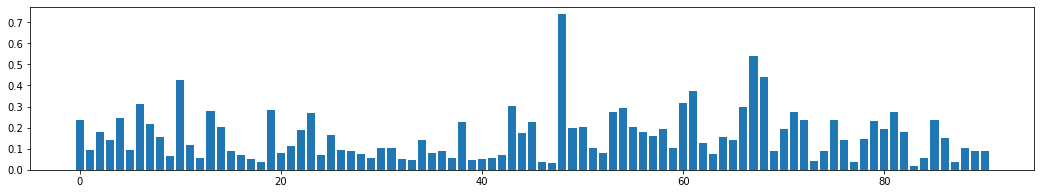

In [74]:
import matplotlib.pyplot as plt

min_v = np.min(all_observations)
max_v = np.max(all_observations + np.abs(min_v))
normalized_obs = (all_observations + np.abs(min_v)) / max_v


x = np.arange(0, all_observations.shape[0], 1)
plt.figure(figsize=(18,3))
plt.bar(x, normalized_obs[:, 10])

In [29]:
np.mean(all_observations, axis = 1), np.std(all_observations, axis=1), np.max(all_observations, axis=1)

(array([-9.57079367e+00, -3.63726850e+01,  8.45571213e+01, -3.93628142e+01,
         4.15709808e+01, -3.95397737e+01,  3.18537319e-05,  5.96016896e+01,
         5.66977001e+01,  4.98704800e+01,  2.66647319e-01,  4.66906427e+00,
         1.04973111e+02, -2.77319215e+01,  2.09632917e+01,  5.10791091e+01,
         1.33491475e+01,  8.34820906e+00,  4.01034014e+00, -7.27689886e+00,
         1.20105877e+02,  8.53920111e+00,  3.99332291e+01,  5.23909576e+01,
        -6.62308169e+00,  2.42719019e+01,  1.28859230e+01,  4.48897972e+01,
         1.95624969e+01, -1.84314128e+01,  1.63584572e+01,  3.13679326e+01,
        -1.50490481e+01, -4.16275742e+00, -1.29616172e+00,  2.26436169e+01,
        -1.51956447e+01, -1.99493484e+01, -2.74909419e+01, -3.60719003e+01,
        -8.94621915e+00,  6.62841004e+01,  3.61695098e+01, -4.54361427e+01,
         7.01413250e+01,  6.02893684e+01,  2.77789883e+01,  4.94081857e+01,
        -2.63239996e+01, -4.96874558e+01, -6.41513079e+01, -6.05370859e+01,
         4.1

In [50]:
import matplotlib.pyplot as plt

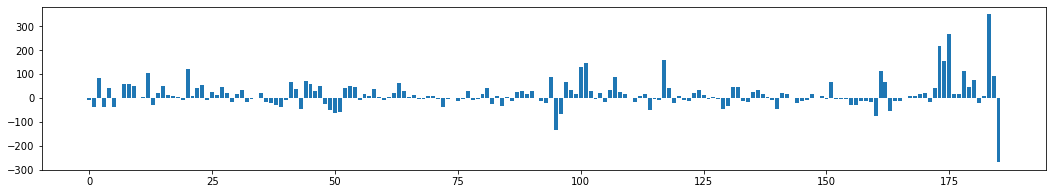

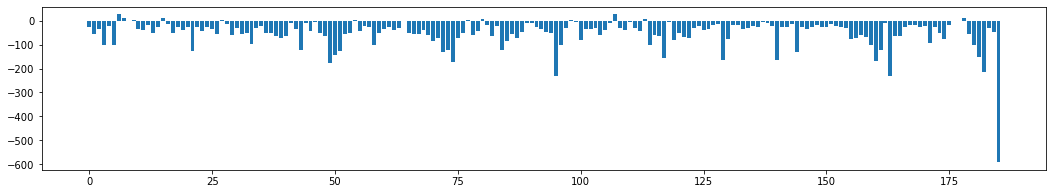

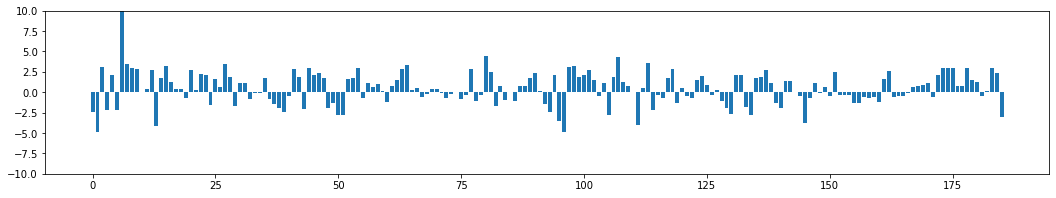

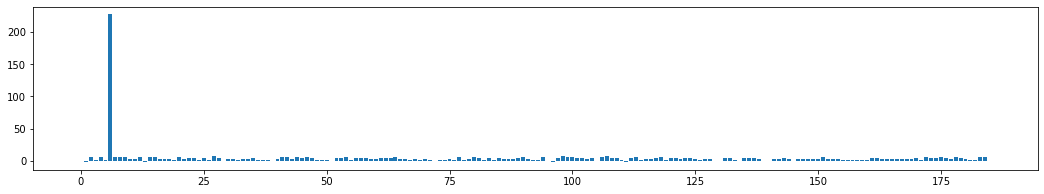

In [99]:
plt.figure(figsize=(18,3))
plt.bar(range(186), np.mean(all_observations, axis = 1))
plt.show()
plt.figure(figsize=(18,3))
plt.bar(range(186),  np.min(all_observations, axis = 1) + (np.mean(all_observations, axis = 1))/(np.max(all_observations, axis = 1) - np.min(all_observations, axis = 1)))
# plt.ylim((0, 0.1))
plt.show()
plt.figure(figsize=(18,3))
plt.bar(range(186), np.mean(all_observations, axis = 1)/np.std(all_observations, axis = 1))
plt.ylim((-10, 10))
plt.show()
# plt.figure(figsize=(18,3))
# plt.bar(range(186), np.max(all_observations, axis = 1))
# plt.show()
# plt.figure(figsize=(18,3))
# plt.bar(range(186), np.std(all_observations, axis = 1))
# plt.show()
plt.figure(figsize=(18,3))
plt.bar(range(186), np.max(all_observations, axis = 1)/np.std(all_observations, axis = 1))
# plt.ylim((0,20))
plt.show()

In [75]:
np.mean(all_observations, axis = 1)

array([ 45.9434787 ,  18.02653617,  35.15120415,  27.07980921,
        46.93192022,  17.14709366,  63.17372893,  42.41664023,
        30.7193657 ,  12.67265858,  81.32586967,  22.54121159,
         9.72993806,  54.1745565 ,  40.59964816,  16.25961843,
        12.65932607,   9.06516105,   6.28884539,  55.83680872,
        15.32566898,  21.60678642,  38.74587463,  53.19757184,
        12.95945986,  33.16879336,  18.50322349,  17.43662042,
        14.26593657,  10.43358028,  19.55837215,  19.55223984,
         9.5382111 ,   8.47762884,  28.05240337,  14.84244549,
        18.02838454,  10.60513875,  46.10410307,   8.95696235,
         8.95497771,   9.53415759,  12.13396433,  59.74093904,
        33.28534192,  44.35718781,   6.34972003,   6.34869426,
       146.31368927,  41.15965807,  40.68626114,  20.60635035,
        14.82064668,  56.03373884,  57.80490584,  39.92312933,
        35.96836224,  32.2827874 ,  37.59486373,  20.60899405,
        68.77222992,  70.773335  ,  26.18512884,  14.43

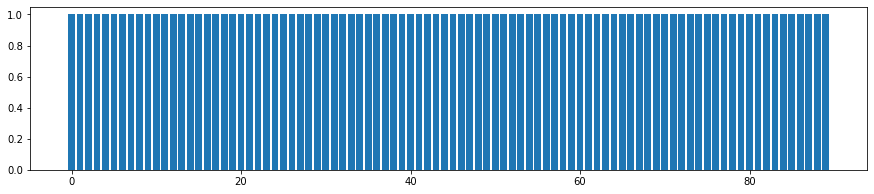

In [82]:
plt.figure(figsize=(15,3))
plt.bar(range(90), np.ones(90))
plt.show()